In [1]:
import sys

if '' in sys.path:
    sys.path.remove('')  # elimina el path actual

import torch
print(torch.__version__)


2.5.1+cu121


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.models as models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import cv2
import numpy as np



In [4]:
# --- Configuración GPU ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)


Usando dispositivo: cuda


In [22]:
# --- Transformación base con Data Augmentation ---
transform_base = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),  # girar ±20°
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

class AddFeaturesImproved:
    """
    Clase para añadir características extra a las imágenes de melanomas:
    - Asimetría horizontal
    - Normalización interna de los canales adicionales
    - Concatenación con los canales RGB originales
    """

    def __call__(self, img_tensor):
        # img_tensor: CxHxW (RGB)
        img_np = img_tensor.permute(1, 2, 0).numpy()  # HxWxC
        gray = cv2.cvtColor((img_np * 255).astype('uint8'), cv2.COLOR_RGB2GRAY)
        gray = gray / 255.0  # volver a rango 0-1

        # --- Asimetría horizontal ---
        mirror = cv2.flip(gray, 1)  # espejo horizontal
        asym = np.abs(gray - mirror)  # diferencia
        # normalizar para que rango sea 0-1
        asym = (asym - asym.min()) / (asym.max() - asym.min() + 1e-8)
        asym_tensor = torch.tensor(asym, dtype=torch.float32).unsqueeze(0)

        # Concatenar con los canales RGB originales
        return torch.cat([img_tensor, asym_tensor], dim=0)  # C+1 x H x W


# --- Transformación completa ---
transform_full = transforms.Compose([
    transform_base,
    AddFeaturesImproved()
])

# --- Cargar datasets ---
train_data = datasets.ImageFolder(
    root=r"C:\Users\josit\CUARTO CURSO\APRENDIZAJE AUTOMATICO\Caso1.-Detecci-n-de-melanomas\data\train",
    transform=transform_full
)
test_data = datasets.ImageFolder(
    root=r"C:\Users\josit\CUARTO CURSO\APRENDIZAJE AUTOMATICO\Caso1.-Detecci-n-de-melanomas\data\test",
    transform=transform_full
)

# --- DataLoaders ---
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

print("Clases:", train_data.classes)

Clases: ['Benign', 'Malignant']


Usando dispositivo: cuda
Epoch 1/40 | Train Loss: 0.4791 | Train Acc: 0.7717 | Val Loss: 0.6263 | Val Acc: 0.7405
Epoch 2/40 | Train Loss: 0.4412 | Train Acc: 0.7976 | Val Loss: 0.4780 | Val Acc: 0.8030
Epoch 3/40 | Train Loss: 0.4313 | Train Acc: 0.7980 | Val Loss: 0.4573 | Val Acc: 0.7895
Epoch 4/40 | Train Loss: 0.4030 | Train Acc: 0.8105 | Val Loss: 0.4537 | Val Acc: 0.7845
Epoch 5/40 | Train Loss: 0.3819 | Train Acc: 0.8239 | Val Loss: 0.3938 | Val Acc: 0.8200
Epoch 6/40 | Train Loss: 0.3574 | Train Acc: 0.8353 | Val Loss: 0.3637 | Val Acc: 0.8330
Epoch 7/40 | Train Loss: 0.3352 | Train Acc: 0.8515 | Val Loss: 0.3344 | Val Acc: 0.8725
Epoch 8/40 | Train Loss: 0.3290 | Train Acc: 0.8556 | Val Loss: 0.3240 | Val Acc: 0.8705
Epoch 9/40 | Train Loss: 0.3143 | Train Acc: 0.8633 | Val Loss: 0.3597 | Val Acc: 0.8330
Epoch 10/40 | Train Loss: 0.3189 | Train Acc: 0.8596 | Val Loss: 0.3323 | Val Acc: 0.8710
Epoch 11/40 | Train Loss: 0.3092 | Train Acc: 0.8627 | Val Loss: 0.3491 | Val Acc: 0

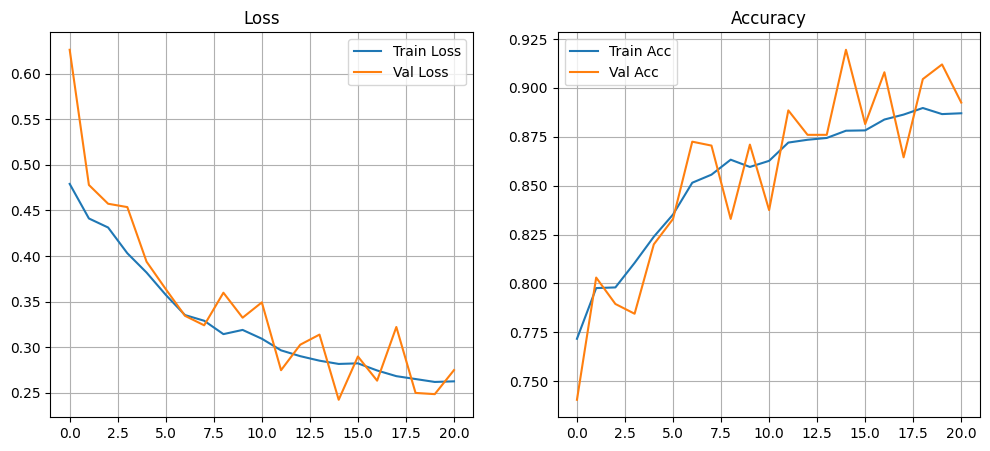

In [ ]:

# --- Configuración GPU ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)


# --- Modelo CNN más profundo ---
class CNNFeatures(nn.Module):
    def __init__(self, num_classes):
        super(CNNFeatures, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(6, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    
    def forward(self,x):
        x = self.features(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)
        return x

model = CNNFeatures(len(train_data.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# --- Entrenamiento con early stopping ---
num_epochs = 40
patience = 6
best_val_loss = float('inf')
counter = 0

train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device).float(), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        correct_train += (outputs.argmax(1) == labels).sum().item()
        total_train += labels.size(0)
    
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # --- Validación ---
    model.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device).float(), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            correct_val += (outputs.argmax(1) == labels).sum().item()
            total_val += labels.size(0)
    val_loss /= len(test_loader.dataset)
    val_acc = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        counter = 0
    else:
        counter +=1
        if counter >= patience:
            print(f"⛔ Early stopping en epoch {epoch+1}")
            break

# --- Guardar mejor modelo ---
if best_model_state:
    torch.save({
        'model_state': best_model_state,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }, 'best_model_features.pth')

# --- Graficar Accuracy y Loss ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend(); plt.grid(True); plt.title("Loss")
plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.legend(); plt.grid(True); plt.title("Accuracy")
plt.show()


In [14]:
model.eval()  # modo evaluación
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.float()
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)  # la clase con mayor probabilidad
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


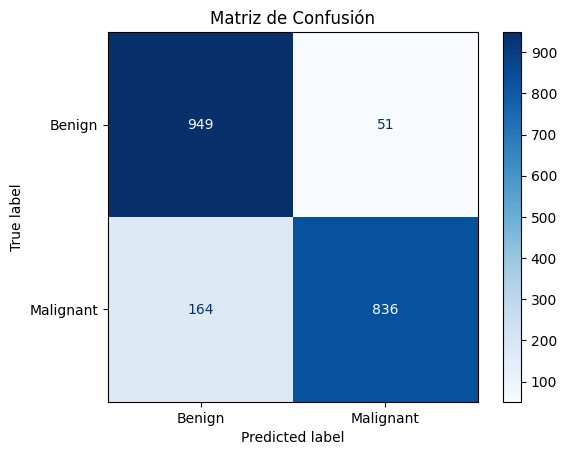

In [15]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_data.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# --- Configuración GPU ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

# --- CNN optimizada para 6 canales (RGB + heatmaps) ---
class CNNMelanoma(nn.Module):
    def __init__(self, num_classes):
        super(CNNMelanoma, self).__init__()

        self.features = nn.Sequential(
            # Bloque 1
            nn.Conv2d(6, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),

            # Bloque 2
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2),

            # Bloque 3
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d(2),

            # Bloque 4
            nn.Conv2d(256, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 256), nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


# --- Instanciar modelo ---
model = CNNMelanoma(len(train_data.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# --- Entrenamiento con early stopping ---
num_epochs = 50
patience = 10
best_val_loss = float('inf')
counter = 0

train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device).float(), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        correct_train += (outputs.argmax(1) == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # --- Validación ---
    model.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device).float(), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            preds = outputs.argmax(1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= len(test_loader.dataset)
    val_acc = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # --- Scheduler ---
    scheduler.step(val_loss)

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{num_epochs} | LR: {current_lr:.6f} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # --- Early stopping ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"⛔ Early stopping en epoch {epoch+1}")
            break

# --- Guardar mejor modelo ---
if best_model_state:
    torch.save({
        'model_state': best_model_state,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }, 'best_model_melanoma_6ch.pth')

# --- Graficar ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend(); plt.grid(True); plt.title("Loss")
plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.legend(); plt.grid(True); plt.title("Accuracy")
plt.show()


Usando dispositivo: cuda


KeyboardInterrupt: 

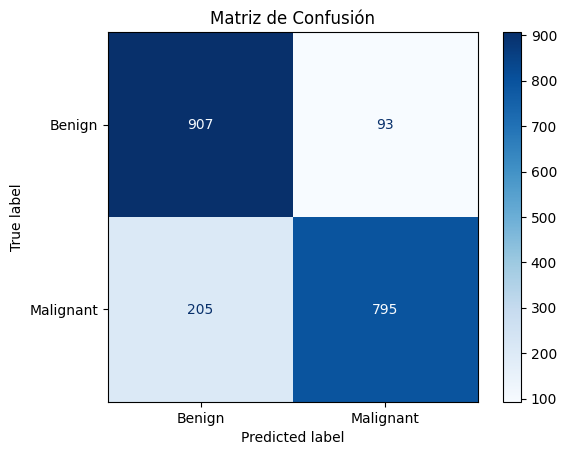

In [31]:
model.eval()  # modo evaluación
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.float()
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)  # la clase con mayor probabilidad
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_data.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()



Usando dispositivo: cuda
Epoch 1/60 | Train Loss: 0.5427 | Train Acc: 0.7557 | Val Loss: 0.5148 | Val Acc: 0.7485
Epoch 2/60 | Train Loss: 0.4668 | Train Acc: 0.7810 | Val Loss: 0.4966 | Val Acc: 0.7660
Epoch 3/60 | Train Loss: 0.4538 | Train Acc: 0.7826 | Val Loss: 0.4966 | Val Acc: 0.7575
Epoch 4/60 | Train Loss: 0.4431 | Train Acc: 0.7899 | Val Loss: 0.4963 | Val Acc: 0.7525
Epoch 5/60 | Train Loss: 0.4343 | Train Acc: 0.7921 | Val Loss: 0.4915 | Val Acc: 0.7630
Epoch 6/60 | Train Loss: 0.4302 | Train Acc: 0.7964 | Val Loss: 0.4595 | Val Acc: 0.7895
Epoch 7/60 | Train Loss: 0.4232 | Train Acc: 0.7993 | Val Loss: 0.4558 | Val Acc: 0.7840
Epoch 8/60 | Train Loss: 0.4205 | Train Acc: 0.8002 | Val Loss: 0.4418 | Val Acc: 0.8035
Epoch 9/60 | Train Loss: 0.4173 | Train Acc: 0.8008 | Val Loss: 0.4529 | Val Acc: 0.7930
Epoch 10/60 | Train Loss: 0.4105 | Train Acc: 0.8078 | Val Loss: 0.4534 | Val Acc: 0.7850
Epoch 11/60 | Train Loss: 0.4038 | Train Acc: 0.8134 | Val Loss: 0.4352 | Val Acc: 0

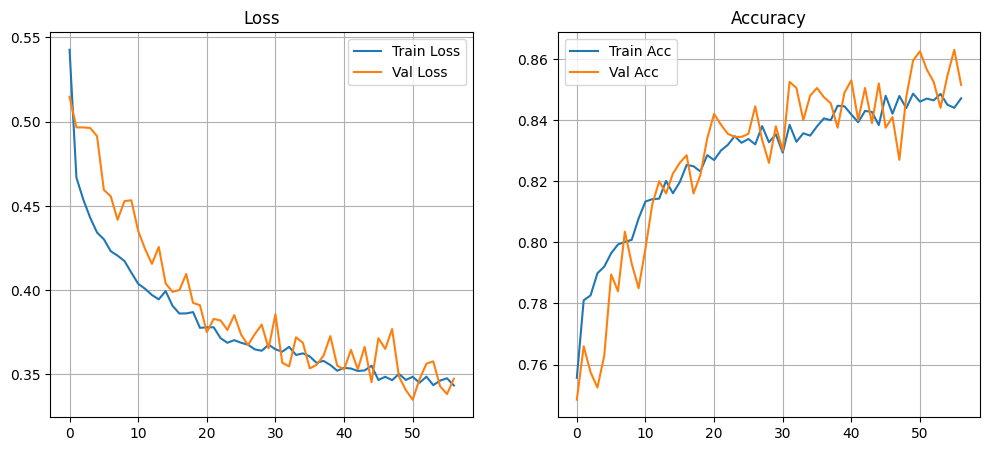

In [30]:


# --- Configuración GPU ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

# --- Modelo CNN optimizado ---
# --- CNN ligera que acepta 4 canales ---
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(4, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),

            nn.AdaptiveAvgPool2d((1,1))
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, len(train_data.classes))
        )


    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)


# --- Instanciar modelo ---
model = CNNMelanomaLight(len(train_data.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00003, weight_decay=1e-4)

# --- Early Stopping ---
num_epochs = 60
patience = 6
best_val_loss = float('inf')
counter = 0
best_model_state = None

train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

# --- Entrenamiento ---
for epoch in range(num_epochs):
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device).float(), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        correct_train += (outputs.argmax(1) == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # --- Validación ---
    model.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device).float(), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            correct_val += (outputs.argmax(1) == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= len(test_loader.dataset)
    val_acc = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # --- Early Stopping ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"⛔ Early stopping en epoch {epoch+1}")
            break


# --- Guardar mejor modelo ---
if best_model_state:
    torch.save(best_model_state, 'cnn_melanoma_light_const_lr.pth')

# --- Gráficas ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend(); plt.grid(True); plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.legend(); plt.grid(True); plt.title("Accuracy")

plt.show()
